# Data Assimilation workflow cleanup using Global Winds

In [20]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
from dsfunctions import geom_to_vector, reproject_geom, validate_geom

import farsiteutils_v2 as futils
import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

from shapely.geometry import Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
import contextily as ctx

description = 'Bridge2021'

In [21]:
def calculate(initialidx, 
              observeidx,
              windspeed, winddirection, 
              usr: futils.User):

    lcpidx = usr.db.dfLandscape.index[0]
    barrieridx = usr.db.dfBarrier.index[0]
    
    # Setup the input data
    inputData = {'description': 'Maria_2019',
                 'igniteidx'  : initialidx,
                 'compareidx' : observeidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr.calculatePerimeters(inputData)
    mainapi.run_farsite()

def forward_pass_farsite(poly, params):
    '''
        params: take values: 'windspeed', 'winddirection' ,'dt' (dt is a datetime.timedelta object)
                              'description' (Maria2019, Bridge2021, River2021)
    '''
    # Parameters to run the simulation
    windspeed = params['windspeed']
    winddirection = params['winddirection']
    dt = params['dt']
    description = params['description']
    
    # Create handles for simulation
    fp = futils.FilePaths('/home/jovyan/data/')
    usr = futils.User(fp, description)

    initialidx = uuid.uuid4().hex
    fpath = f'/home/jovyan/farsite-devAPI/inputs/Reference/{description}_{initialidx}.shp'
    # Creating the shp file for simulation
    gpd.GeoDataFrame({'FID': [0], 'geometry':poly}, crs='EPSG:5070').to_file(fpath)
    
    usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation', 
                                                                                               fpath, datetime.datetime.now(),
                                                                                               description]
    
    observeidx = uuid.uuid4().hex
    # Add observationidx only to calculate the dt in the backend
    usr.db.dfObservation.loc[observeidx, 'datetime'] = usr.db.dfObservation.loc[initialidx, 'datetime'] + dt
    
    
    # Run simulation for dt from initialidx
    calculate(initialidx, observeidx, windspeed, winddirection, usr)
    
    # add simulation as the next initial point
    try:
        dfsim = usr.db.dfsimulation[(usr.db.dfsimulation['igniteidx'] == initialidx) & 
                                (usr.db.dfsimulation['compareidx'] == observeidx)]
    except KeyError as e:
        print(e)
        print(usr.db.dfsimulation)
        return None
    
    if len(dfsim) < 1:
        return None
    
    # assert(len(dfsim) == 1) , f'Length of dfsim = {len(dfsim)}'
    if len(dfsim) != 1:
        raise ValueError(f'Length of dfsim = {len(dfsim)}')

    usr.db.dfObservation.loc[dfsim.index[0], ['filetype', 'description']] = ['Observation', description]
    
    simpath = f'/home/jovyan/farsite-devAPI/inputs/Reference/{description}_{observeidx}.shp'
    dfgeom = gpd.read_file(dfsim['filepath'].iloc[0])['geometry']
    assert(len(dfgeom) == 1), f'dfgeom has size = {len(dfgeom)}'
    dfgeom = dfgeom[0]

    # Remove the generated files
    !rm /home/jovyan/farsite-devAPI/inputs/Reference/*
    
    return Polygon(dfgeom.coords)




####################################################
####################################################
def calculate_rms_state(state1, state2):
    return ((state1 - state2)**2).mean()
def calculate_area_diff_state(state1, state2):
    geom1 = Polygon(zip(state1[::2], state1[1::2]))
    geom2 = Polygon(zip(state2[::2], state2[1::2]))
    
    return (geom1.union(geom2) - geom1.intersection(geom2)).area
def align_states(state_lst, vertex_count=None):
    if vertex_count is None:
        vertex_count = max(len(st) for st in state_lst)//2
    x0 = state_lst[0][::2]
    y0 = state_lst[0][1::2]
    x1 = state_lst[1][::2]
    y1 = state_lst[1][1::2]

    geom0 = Polygon(zip(x0,y0))
    geom1 = Polygon(zip(x1,y1))

    geom0, geom1 = align_geoms([geom0, geom1], vertex_count)
    x,y = geom0.exterior.coords.xy
    x0 = x.tolist()[:-1]
    y0 = y.tolist()[:-1]
    state0 = xy_to_state(x0, y0)
    
    x,y = geom1.exterior.coords.xy
    x1 = x.tolist()[:-1]
    y1 = y.tolist()[:-1]
    state1 = xy_to_state(x1, y1)

    return [state0, state1]
    
def xy_to_state(x, y):
    ret = []
    for i in range(len(x)):
        ret.append(x[i])
        ret.append(y[i])

    return np.array(ret).reshape((2*len(x),1))

def state_to_xy(state):
    return state[::2], state[1::2]

def sample_xy(x,y, rng):
    xs = rng.normal(x, scale=100)
    ys = rng.normal(y, scale=100)

    return xs,ys



def adjusted_state_EnKF_farsite(initial_state, observation_state, 
                        X, n_states, n_samples, rng, 
                        sampled_wslst, sampled_wdlst, dt,
                                description):

    xkhat_ensemble = np.zeros((n_states, n_samples))
    wk_ensemble = np.zeros((n_states, n_samples))
    vk_ensemble = np.zeros((n_output, n_samples))
    
    zkphat_ensemble = np.zeros((n_states, n_samples))
    xkphat_ensemble = np.zeros((n_states, n_samples))
    ykhat_ensemble = np.zeros((n_output, n_samples))
    
    Xs = np.linalg.cholesky(X)
    # For each sample
    zero_samples = []
    for s in tqdm(range(n_samples)):
    
        xkhat_ensemble[:,s:(s+1)] = initial_state + np.matmul(Xs, rng.normal(size=(n_states,1)))
    
        ws = sampled_wslst[s]
        wd = sampled_wdlst[s]
        
        ykhat_ensemble[:,s:(s+1)] = xy_to_state(*sample_xy(observation_state[::2],observation_state[1::2],rng))
########################################
        forward_geom = forward_pass_farsite(Polygon(zip(xkhat_ensemble[:,s:(s+1)][::2], xkhat_ensemble[:,s:(s+1)][1::2])),
                                            {'windspeed': int(ws),
                                             'winddirection': int(wd),
                                             'dt': dt,
                                             'description': description})
        if forward_geom is None:
            zero_samples.append(s)
            continue
            
        forward_state = geom_to_vector(forward_geom)
        aligned_states = align_states([initial_state, forward_state], vertex_count = n_vertex)
        
        zkphat_ensemble[:,s:(s+1)] = aligned_states[1]
########################################
        

    # Calculate the mean of the non-zero ensembles
    zkphat_mean = zkphat_ensemble.sum(axis=1, keepdims=True)/(n_samples - len(zero_samples))
    
    # Fill in the zero samples with the mean
    for s in zero_samples:
        zkphat_ensemble[:,s:(s+1)] = zkphat_mean
    
    filled_counts = len(zero_samples)
    
    # zkphat_mean = zkphat_ensemble.mean(axis=1, keepdims=True)
    ykhat_mean = ykhat_ensemble.mean(axis=1, keepdims=True)
    
    # Calculate errors
    # zkphat_ensemble -= zkphat_mean
    # ykhat_ensemble -= ykhat_mean
    ezkphat_ensemble = np.zeros_like(zkphat_ensemble)
    for n in range(n_states):
        ezkphat_ensemble[n:(n+1),:] = zkphat_ensemble[n:(n+1),:] - zkphat_mean[n]
    
    eykhat_ensemble = np.zeros_like(ykhat_ensemble)
    for n in range(n_output):
        eykhat_ensemble[n:(n+1),:] = ykhat_ensemble[n:(n+1),:] - ykhat_mean[n]
    
    Pzy = 1/n_samples*np.matmul(ezkphat_ensemble, eykhat_ensemble.T)
    
    Py = 1/n_samples*np.matmul(eykhat_ensemble, eykhat_ensemble.T)
    Pyinv = np.linalg.pinv(Py)

    inv_product = np.matmul(Py, Pyinv)
    if not np.allclose(inv_product, np.eye(n_output)):
        print('Inverse calculation is incorrect')
        display(inv_product)
        
    # warnings.warn('Not checking the inverse calculation')
    
    # Compute estimated Kalman gain based on correlations
    L_EnKF = np.matmul(Pzy, Pyinv)
    
    # compute mean valued state adjustment using measurement y(k)
    # yk = geom_to_state(observation['geometry'], n_states, nvertex)
    yk = observation_state
    adjusted_state = zkphat_mean + np.matmul(L_EnKF, yk - ykhat_mean)
    
    # Compute the state adjustment ensembles to update state covariance matrix X
    for j in range(n_samples):
        xkphat_ensemble[:,j:(j+1)] = zkphat_ensemble[:,j:(j+1)] + np.matmul(L_EnKF, yk - ykhat_ensemble[:,j:(j+1)])
    
    # xkphat_ensemble -= xkphat_ensemble.mean(axis=1, keepdims=True)
    xkphat_mean = xkphat_ensemble.mean(axis=1, keepdims=True)
    exkphat_ensemble = np.zeros_like(xkphat_ensemble)
    for n in range(n_states):
        exkphat_ensemble[n:(n+1), :] = xkphat_ensemble[n:(n+1),:] - xkphat_mean[n]
    
    X = 1/n_samples*np.matmul(exkphat_ensemble, exkphat_ensemble.T) + 1e-10*np.eye(n_states)
    
    return adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble

# Setup Maria Fire observations

In [22]:
for tix in range(10):
    try:
        obs, ts = get_observation(description, tix)
    except Exception as e:
        print(e)
        print(f'No observation found for tix={tix}')
        break

tfin = tix

'/home/jovyan/farsite/inputs/landscapes/Bridge2021.lcp' not recognized as a supported file format.
No observation found for tix=6


In [23]:
# MAria Fire wind values
# # Windspeed and Wind direction that were used live
# wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
# wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

# Bridge fire wind values
wslst = [15]*(tfin)
wdlst = [270]*(tfin)

# River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

n_vertex = 20
n_samples = 250
wssigma = 4
wdsigma = 15
rng = np.random.Generator(np.random.PCG64(1234))

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in range(tfin):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)
    sampled_wslst.append([])
    sampled_wdlst.append([])
    for s in range(n_samples):
        sampled_wslst[-1].append(sample_windspeed(wslst[tix],wssigma,rng))
        sampled_wdlst[-1].append(sample_winddirection(wdlst[tix], wdsigma, rng))

2021-09-05 14:04:52
0 days 00:00:00
0 days 00:29:37
0 days 00:57:24
0 days 01:20:28
0 days 01:53:35
0 days 02:18:39


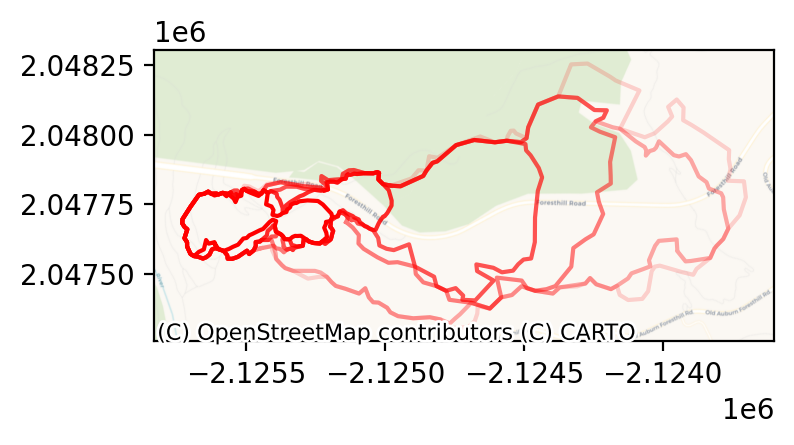

In [24]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

print(timestamps[0])
for i, (geom, dt) in enumerate(zip(observations, timestamps)):
    plot_geometry(validate_geom(geom), ax=ax, color='red', alpha=1-i/len(observations))
    print(dt - timestamps[0])

# Maria boundaries
# ax.set_xlim(-2.091e6, -2.081e6)
# ax.set_ylim(1.498e6, 1.508e6)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)


ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Voyager, crs='EPSG:5070')

### Compare the farsite output to the Data Assimilation output

1. Start with an ignition at 6:13pm and simulate until the first observation
2. Compare the first observation to the simulated output, compute error
3. At this point, there are two options.
   - Option 1: Use the first observation as the initial of the next simulation.
   - Option 2: Use data assimilation to incorporate observation to have a fully continuous simulation

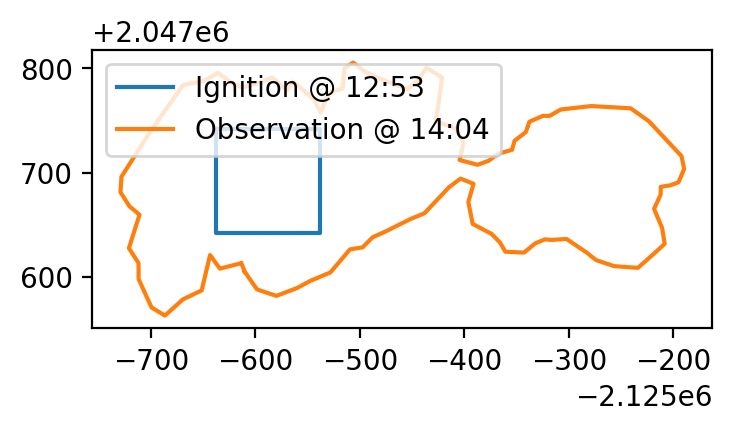

In [25]:
# # Maria ignition
# ignition_timepoint = timestamps[0].replace(hour=18, minute=13)
# x,y = (-2084217.1484733422, 1503560.461310427)
# width = 200
# xshift = 2000
# yshift = 1500


# Bridge2021 ignition
ignition_timepoint = timestamps[0].replace(hour=12, minute=53)
x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
width = 100
xshift = -50
yshift = 50



# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax, label=f'Ignition @ {ignition_timepoint.strftime("%H:%M")}')
plot_geometry(observations[0], ax=ax, label=f'Observation @ {timestamps[0].strftime("%H:%M")}')
ax.legend(loc='upper left')

model_output_lst = []
adjusted_geom_lst = []
X_lst = []
xkhat_ensemble_lst = []
xkphat_ensemble_lst = []
ykhat_ensemble_lst = []
zkphat_ensemble_lst = []

In [26]:
# Run farsite from ignition to the first observation
dt = timestamps[0] - ignition_timepoint
wd = wdlst[0]
ws = wslst[0]

model_output = forward_pass_farsite(ignition, {'windspeed': ws,
                                                     'winddirection': wd,
                                                     'dt': dt,
                                                     'description': description})
model_output_lst.append(model_output)

###########################################
#### CALCULATE ADJUSTED MODEL OUTPUT ######
###########################################
# Input of data assimilation
n_states = 2*n_vertex
n_output = n_states
tix = 0
initial_state = geom_to_vector(ignition)
observation_state = geom_to_vector(validate_geom(observations[tix]))

X = 1e5*np.eye(n_states)  # Initial covariance matrix
initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
    initial_state, observation_state, X, n_states, n_samples, 
    rng, sampled_wslst[tix], sampled_wdlst[tix], dt, 
    description)

adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
adjusted_geom_lst.append(adjusted_geom)
X_lst.append(X)
xkhat_ensemble_lst.append(xkhat_ensemble)
xkphat_ensemble_lst.append(xkphat_ensemble)
ykhat_ensemble_lst.append(ykhat_ensemble)
zkphat_ensemble_lst.append(zkphat_ensemble)

100%|██████████| 250/250 [01:58<00:00,  2.10it/s]


Calculating 19/20..    


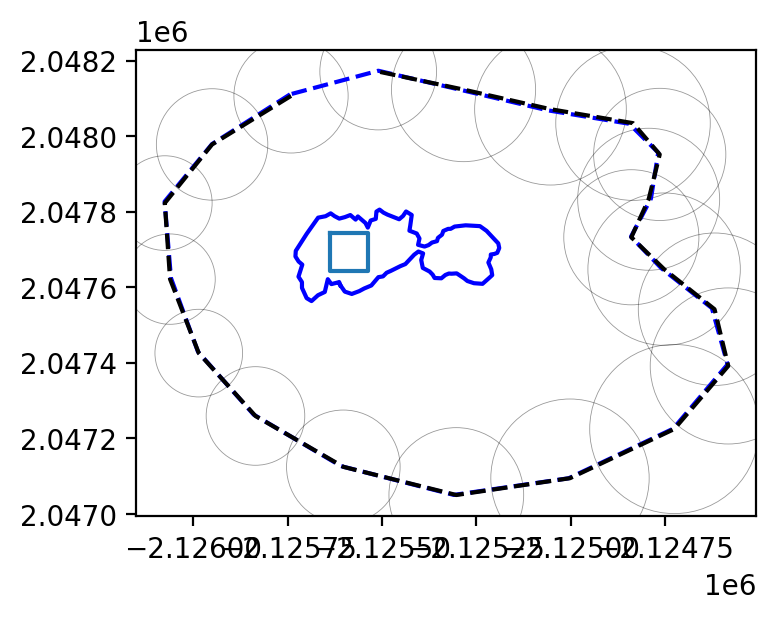

In [29]:
# X=1e2
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(zkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)

In [ ]:
# X=1e4 - std=10000
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(zkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)

In [ ]:
# X=1e4 - std=100
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(zkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)

In [ ]:
# X=1e6
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(ignition, ax=ax)
plot_geometry(observations[0], ax=ax, color='blue')
plot_geometry(adjusted_geom, ax=ax, color='blue', ls='--')
plot_matrix(zkphat_ensemble, ax=ax, color='black', ls='--', show_stdev=True)

In [30]:
%%time

# Run farsite for the rest of the time

for tix in range(1,tfin):
    print(f'\nCalculating {tix}/{tfin}...')
    dt = timestamps[tix] - timestamps[tix-1]
    wd = wdlst[tix]
    ws = wslst[tix]
    
    model_output = forward_pass_farsite(observations[tix-1], {'windspeed': ws,
                                                         'winddirection': wd,
                                                         'dt': dt*2,
                                                            'description': description})
    model_output_lst.append(model_output)
    
    
    ###########################################
    #### CALCULATE ADJUSTED MODEL OUTPUT ######
    ###########################################
    initial_state = geom_to_vector(adjusted_geom_lst[tix-1])
    observation_state = geom_to_vector(validate_geom(observations[tix]))
    
    initial_state, observation_state = align_states([initial_state, observation_state], vertex_count=n_vertex)
    adjusted_state, X, zkphat_ensemble, xkhat_ensemble, ykhat_ensemble, xkphat_ensemble = adjusted_state_EnKF_farsite(
        initial_state, observation_state, X, 
        n_states, n_samples, rng, 
        sampled_wslst[tix], sampled_wdlst[tix], dt,
        description)
    
    adjusted_geom = Polygon(zip(adjusted_state[::2], adjusted_state[1::2]))
    adjusted_geom_lst.append(adjusted_geom)
    X_lst.append(X)
    xkhat_ensemble_lst.append(xkhat_ensemble)
    xkphat_ensemble_lst.append(xkphat_ensemble)
    ykhat_ensemble_lst.append(ykhat_ensemble)
    zkphat_ensemble_lst.append(zkphat_ensemble)


Calculating 1/6...


100%|██████████| 250/250 [01:20<00:00,  3.10it/s]


Calculating 2/6...



100%|██████████| 250/250 [01:18<00:00,  3.19it/s]


Calculating 3/6...



100%|██████████| 250/250 [01:14<00:00,  3.36it/s]


Calculating 4/6...



100%|██████████| 250/250 [01:26<00:00,  2.88it/s]


Calculating 5/6...



100%|██████████| 250/250 [01:19<00:00,  3.13it/s]

CPU times: user 1min 6s, sys: 35.7 s, total: 1min 42s
Wall time: 6min 41s


In [31]:
import pickle

fname = f'./{description}_results_07112024_n20_sz100_x1e5.pkl'

data = {'adjusted_geom': adjusted_geom_lst,
        'xkhat_ensemble_lst': xkhat_ensemble_lst,
        'xkphat_ensemble_lst': xkphat_ensemble_lst,
        'ykhat_ensemble_lst': ykhat_ensemble_lst,
        'zkphat_ensemble_lst': zkphat_ensemble}
with open(fname, 'wb') as f:
    pickle.dump(data, f)

print(fname)

./Bridge2021_results_07112024_n20_sz100_x1e5.pkl
